In [1]:
import numpy as np

import json
with open('rho_values.txt') as f:
    json_data = json.load(f)

In [2]:
import calc_mixing_bz_new as cm
import math
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
z0 = 8 # Depth of mixed layer [m]
rho1 = 1022.49 # Density of mixed layer (used as reference density rho0)
rho2 = 1024.12 # Density of deeper ocean
mu = 2e-3 # Salt-mass diffusivity [m^2/s]
g = 9.8 # Acceleration due to gravity [m/s^2]
L = 960 # Domain length [m]
H = 80 # Domain height [m]
l = 75*z0 # Keel center location [m]
Nx = 1280 # Number of grid points in horizontal
Nz = 640 # Number of grid points in vertical
Nx_f = math.ceil(Nx/L*(L-5*z0))
Nx_i = math.floor(Nx/L*(20*z0))
x = np.linspace(0, L, Nx) # Horizontal grid points [m]
z = np.linspace(0, H, Nz) # Vertical grid points (increasing downwards) [m]
dx = L/Nx # Grid spacing in x
dz = H/Nz # Grid spacing in z
vol = dx*dz # "Volume" (area) of each grid cell

zv, xv = np.meshgrid(z,x) # create meshgrid of (x,z) coordinates

Nx_mid = int(np.where(np.abs(x-l) == np.min(np.abs(x-l)))[0])
rho_mid = (rho1+rho2)/2

In [4]:
def name_to_h(name,z0):
    if name[-2::]=='05':
        h = 0.5*z0
    elif name[-2::]=='09':
        h = 0.95*z0
    elif name[-2::]=='12':
        h = 1.2*z0
    else:
        h = 2.0*z0
    return h

In [ ]:
def plot_relevant_stuff(name):
    
    rho = json_data[name][-1][1] #density at the second time
    rho = np.array(rho) 
    rho = np.array(rho)[:, ::-1]
    h = name_to_h(name,z0)
    keel_mask = cm.find_mask(h, l, Nx, Nz, zv)
    #Calculate upstream
    b_up1, zs_up1, mixing_up1, dzdb_up1 = cm.calc_mixing(rho, h, l, Nx, Nz, zv, Nx_i, Nx_mid, dz, vol, 1, x, z, keel_mask)

    #Calculate downstream
    b_down1, zs_down1, mixing_down1, dzdb_dn1 = cm.calc_mixing(rho,h,l,Nx,Nz,zv,Nx_mid,Nx_f,dz,vol,0,x,z, keel_mask)
    nabla_rho1 = cm.rho_deriv(rho,x,z)
    
    
    fig, axs = plt.subplots(4, 2, sharey=True)
    ax1 = axs[0,0]
    c = ax1.imshow(np.transpose((rho[Nx_i:Nx_mid,:]-rho_mid)/rho_mid), vmin=-1.25e-3, vmax=1.25e-3,
                       cmap='bwr', 
                       extent=(0, l/z0, H/z0, 0))
    ax1.set_xlim(0, l/z0)
    ax1.set_ylim(H/(2*z0), 0)
    ax1.set_aspect('auto')
    ax1.fill_between(x/z0, 0, cm.keel(h, l, x)/z0, facecolor="gray", zorder=10)
    cbar = fig.colorbar(c, ax=ax1, orientation='horizontal', pad=0.2)
    ax1.set_title('(a) ' + name + ': $(\\rho-\\Delta \\rho)/\\Delta \\rho$ upstream at $t=t_2$')

    ax2 = axs[0,1]
    c = ax2.imshow(np.transpose((rho[Nx_mid:Nx_f,:]-rho_mid)/rho_mid), vmin=-1.25e-3, vmax=1.25e-3,
                        cmap='bwr', 
                        extent=(l/z0, L/z0, H/z0, 0))
    ax2.set_xlim(l/z0, L/z0)
    ax2.set_ylim(H/(2*z0), 0)
    ax2.set_aspect('auto')
    ax2.fill_between(x/z0, 0, cm.keel(h, l, x)/z0, facecolor="gray", zorder=10)
    cbar = fig.colorbar(c, ax=ax2, orientation='horizontal', pad=0.2)
    ax2.set_title('(b) ' + name + ': $(\\rho-\\Delta \\rho)/\\Delta \\rho$ downstream at $t=t_2$')

    ax1 = axs[1,0]
    c = ax1.imshow(np.transpose(np.log10(mixing_up1)), vmin=-1, vmax=1,
                       cmap='hot_r', 
                       extent=(0, l/z0, H/z0, 0))
    ax1.set_xlim(0, l/z0)
    ax1.set_ylim(H/(2*z0), 0)
    ax1.set_aspect('auto')
    ax1.fill_between(x/z0, 0, cm.keel(h, l, x)/z0, facecolor="gray", zorder=10)
    cbar = fig.colorbar(c, ax=ax1, orientation='horizontal', pad=0.2)
    ax1.set_title('(c) ' + name + ': $log_{10}(mixing_{up})$ at $t=t_2$')

    ax2 = axs[1,1]
    c = ax2.imshow(np.transpose(np.log10(mixing_down1)), vmin=-1, vmax=1,
                        cmap='hot_r', 
                        extent=(l/z0, L/z0, H/z0, 0))
    ax2.set_xlim(l/z0, L/z0)
    ax2.set_ylim(H/(2*z0), 0)
    ax2.set_aspect('auto')
    ax2.fill_between(x/z0, 0, cm.keel(h, l, x)/z0, facecolor="gray", zorder=10)
    cbar = fig.colorbar(c, ax=ax2, orientation='horizontal', pad=0.2)
    ax2.set_title('(d) ' + name + ': $log_{10}(mixing_{down})$ at $t=t_2$')

    ax3 = axs[2,0]
    c = ax3.imshow(np.transpose(nabla_rho1[Nx_i:Nx_mid,:]), vmin=0, vmax=0.5,
                        cmap='hot_r', 
                        extent=(0, l/z0, H/z0, 0))
    ax3.set_xlim(0, l/z0)
    ax3.set_ylim(H/(2*z0), 0)
    ax3.set_aspect('auto')
    ax3.fill_between(x/z0, 0, cm.keel(h, l, x)/z0, facecolor="gray", zorder=10)
    cbar = fig.colorbar(c, ax=ax3, orientation='horizontal', pad=0.2)
    ax3.set_title('(e) ' + name + ': $(\\nabla \\rho)^2$ upstream');

    ax4 = axs[2,1]
    c = ax4.imshow(np.transpose(nabla_rho1[Nx_mid:Nx_f,:]), vmin=0, vmax=0.5,
                       cmap='hot_r', 
                       extent=(l/z0, L/z0, H/z0, 0))
    ax4.set_xlim(l/z0, L/z0)
    ax4.set_ylim(H/(2*z0), 0)
    ax4.set_aspect('auto')
    ax4.fill_between(x/z0, 0, cm.keel(h, l, x)/z0, facecolor="gray", zorder=10)
    cbar = fig.colorbar(c, ax=ax4, orientation='horizontal', pad=0.2)
    ax4.set_title('(f) ' + name + ': $(\\nabla \\rho)^2$ downstream');

    ax1 = axs[3,0]
    c = ax1.imshow(np.transpose(np.log10(dzdb_up1)), vmin=-1, vmax=2,
                       cmap='hot_r', 
                       extent=(0, l/z0, H/z0, 0))
    ax1.set_xlim(0, l/z0)
    ax1.set_ylim(H/(2*z0), 0)
    ax1.set_aspect('auto')
    ax1.fill_between(x/z0, 0, cm.keel(h, l, x)/z0, facecolor="gray", zorder=10)
    cbar = fig.colorbar(c, ax=ax1, orientation='horizontal', pad=0.2)
    ax1.set_title('(g) ' + name + ': $dz^*/d\\rho$ upstream at $t=t_2$')

    ax2 = axs[3,1]
    c = ax2.imshow(np.transpose(np.log10(dzdb_dn1)), vmin=-1, vmax=2,
                        cmap='hot_r', 
                        extent=(l/z0, L/z0, H/z0, 0))
    ax2.set_xlim(l/z0, L/z0)
    ax2.set_ylim(H/(2*z0), 0)
    ax2.set_aspect('auto')
    ax2.fill_between(x/z0, 0, cm.keel(h, l, x)/z0, facecolor="gray", zorder=10)
    cbar = fig.colorbar(c, ax=ax2, orientation='horizontal', pad=0.2)
    ax2.set_title('(h) ' + name + ': $dz^*/d\\rho$ downstream at $t=t_2$')

    fig.set_size_inches(12, 16)
    fig.savefig(name + '.pdf')
    plt.close();

In [5]:
sim_list = list(json_data.keys())

In [ ]:
for name in sim_list:
    plot_relevant_stuff(name)

In [6]:
import pandas as pd
mixing_df = pd.DataFrame(index=sim_list,columns=['Phi_up','Phi_down','K_up','K_down','N2_up','N2_down'])

In [7]:
def get_mixing(name):
    rho = json_data[name][-1][1] #density at the second time
    rho = np.array(rho) 
    rho = np.array(rho)[:, ::-1]
    h = name_to_h(name,z0)
    phi_up, phi_dn, k_up, k_down, zm_up, zm_down = cm.mixing_format(rho, name)
    return phi_up, phi_dn, k_up, k_down, zm_up, zm_down

In [8]:
for name in sim_list:
    phi_up, phi_down, k_up, k_down, n2_up, n2_down = get_mixing(name)
    mixing_df.loc[name,'Phi_up'] = phi_up
    mixing_df.loc[name,'Phi_down'] = phi_down
    mixing_df.loc[name,'K_up'] = k_up
    mixing_df.loc[name,'K_down'] = k_down
    mixing_df.loc[name,'N2_up'] = n2_up
    mixing_df.loc[name,'N2_down'] = n2_down

In [9]:
mixing_df

,Phi_up,Phi_down,K_up,K_down,N2_up,N2_down
F05H05,0.0,0.0,1.0249,1.069759,0.000202,0.000197
F10H05,0.0,0.0,0.99296,0.986496,0.000207,0.000203
F15H05,0.0,0.0,0.97131,0.996467,0.000215,0.000204
F20H05,0.0,0.0,1.036157,1.016576,0.000202,0.000199
F05H09,0.0,0.0,0.828027,1.181899,0.000244,0.000205
F10H09,0.0,0.0,1.035763,0.939508,0.000203,0.000221
F15H09,0.0,0.0,1.01745,1.033761,0.000204,0.000198
F20H09,0.0,0.000001,1.053385,1.909657,0.000206,0.000204
F05H12,0.0,0.000001,0.847468,1.338359,0.000244,0.000198
F10H12,0.0,0.0,1.075255,1.049698,0.000209,0.000203


In [10]:
F = np.array([0.5,1.0,1.5,2.0,0.5,1.0,1.5,2.0,0.5,1.0,1.5,2.0,0.5,1.0,1.5,2.0])
eta = np.array([0.5,0.5,0.5,0.5,0.95,0.95,0.95,0.95,1.2,1.2,1.2,1.2,2.0,2.0,2.0,2.0])
Phi_up = np.array(mixing_df['Phi_up'])
Phi_down = np.array(mixing_df['Phi_down'])
K_up = np.array(mixing_df['K_up'])
K_down = np.array(mixing_df['K_down'])
N2_up = np.array(mixing_df['N2_up'])
N2_down = np.array(mixing_df['N2_down'])

In [ ]:
mixing_json = mixing_df.to_json(orient="columns")
parsed = json.loads(mixing_json)
with open('mixing_data_bz.txt', 'w') as f:
    json.dump(parsed, f)

In [ ]:
import pickle
mixing_df.to_pickle('mixing_df.pkl')

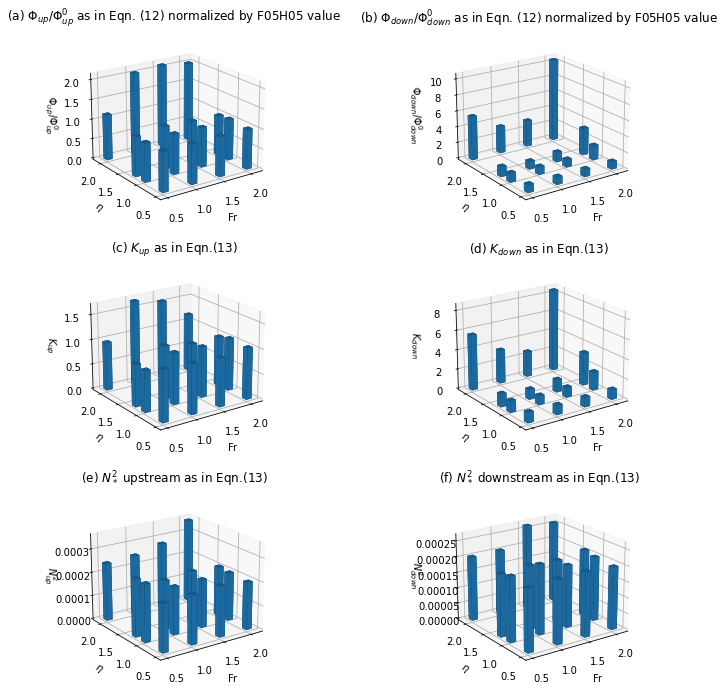

In [11]:
from mpl_toolkits.mplot3d import axes3d
fig = plt.figure()
ax1 = fig.add_subplot(321, projection='3d')

z3 = np.zeros(len(F))
dx = 0.1*np.ones(len(F))
dy = 0.1*np.ones(len(F))

ax1.bar3d(F, eta, z3, dx, dy, Phi_up/Phi_up[0])
ax1.set_xlabel('Fr')
ax1.set_ylabel('$\\eta$')
ax1.set_zlabel('$\\Phi_{up}/\\Phi_{up}^0$')
ax1.view_init(20, -125)
ax1.set_title('(a) $\\Phi_{up}/\\Phi_{up}^0$ as in Eqn. (12) normalized by F05H05 value')

ax2 = fig.add_subplot(322, projection='3d')

ax2.bar3d(F, eta, z3, dx, dy, Phi_down/Phi_down[0])
ax2.set_xlabel('Fr')
ax2.set_ylabel('$\\eta$')
ax2.set_zlabel('$\\Phi_{down}/\\Phi_{down}^0$')
ax2.view_init(20, -125)
ax2.set_title('(b) $\\Phi_{down}/\\Phi_{down}^0$ as in Eqn. (12) normalized by F05H05 value')

ax3 = fig.add_subplot(323, projection='3d')

ax3.bar3d(F, eta, z3, dx, dy, K_up)
ax3.set_xlabel('Fr')
ax3.set_ylabel('$\\eta$')
ax3.set_zlabel('$K_{up}$')
ax3.view_init(20, -125)
ax3.set_title('(c) $K_{up}$ as in Eqn.(13)')

ax4 = fig.add_subplot(324, projection='3d')

ax4.bar3d(F, eta, z3, dx, dy, K_down)
ax4.set_xlabel('Fr')
ax4.set_ylabel('$\\eta$')
ax4.set_zlabel('$K_{down}$')
ax4.view_init(20, -125)
ax4.set_title('(d) $K_{down}$ as in Eqn.(13)')

ax5 = fig.add_subplot(325, projection='3d')

ax5.bar3d(F, eta, z3, dx, dy, N2_up)
ax5.set_xlabel('Fr')
ax5.set_ylabel('$\\eta$')
ax5.set_zlabel('$N^2_{up}$')
ax5.view_init(20, -125)
ax5.set_title('(e) $N_*^2$ upstream as in Eqn.(13)')

ax6 = fig.add_subplot(326, projection='3d')

ax6.bar3d(F, eta, z3, dx, dy, N2_down)
ax6.set_xlabel('Fr')
ax6.set_ylabel('$\\eta$')
ax6.set_zlabel('$N^2_{down}$')
ax6.view_init(20, -125)
ax6.set_title('(f) $N_*^2$ downstream as in Eqn.(13)')


fig.set_size_inches(12, 12)
fig.savefig('mixing_k2.pdf')